In [6]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.cluster import DBSCAN, MeanShift
import math
from itertools import combinations
from skimage.morphology import skeletonize
from scipy.stats import mode 
import copy
import random

In [ ]:
def plot_images(image1, image2, title1="Image 1", title2="Image 2"):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.axis('on')

    plt.show()

def plot_images1(image1,  title1="Image 1"):
    plt.figure(figsize=(12, 6))
    
    plt.imshow(image1, cmap='gray')
    plt.axis('on')

    plt.show()

In [8]:
class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.AB = (self.x2 - self.x1, self.y2 - self.y1)
        
        self.orientation = self.set_orientation()
        self.list_dis = self.dis_from_ref(384, 384)

    def set_orientation(self):
        angle = self.calculate_angle()
        if angle > 180: 
            angle = angle - 180
        
        if angle > 90: 
            angle = 180 - angle

        if angle >= 45:
            return "vertical"
        else:
            return "horizontal"
    
        
    def calculate_angle(self):
        ox = (1,0)
        A = (self.x1, self.y1)
        B = (self.x2, self.y2)
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        mag_AB = np.sqrt(AB[0]**2 + AB[1]**2)
        dot_prod = np.dot(AB, ox)
        mag_prod = mag_AB * 1
        angle = math.acos(dot_prod / mag_prod)  
        
        return math.degrees(angle) % 360
    
    def cross_angle(self,other_line):
        
        A = (self.x1, self.y1)
        B = (self.x2, self.y2)
        AB = (self.x2 - self.x1, self.y2 - self.y1)
        
        C = (other_line.x1, other_line.y1)
        D = (other_line.x2, other_line.y2)
        CD = (other_line.x2 - other_line.x1, other_line.y2 - other_line.y1)        
        
        mag_AB = np.sqrt(round(AB[0]**2 + AB[1]**2,15))
        mag_CD = np.sqrt(round(CD[0]**2 + CD[1]**2,15))
        
        dot_prod = round(np.dot(AB, CD),15)
        mag_prod = round(mag_AB * mag_CD,15)
#         print(dot_prod)
#         print(mag_prod)
        angle = math.acos(round(dot_prod / mag_prod))  
        return math.degrees(angle) % 360
        
        
        
    def dis_from_ref(self,width, length):

        
        point1 = (width* (5/7),length* 0.5)
        point2 = (width /6,length *(6/7))        
        point3 = (width* (3.5/9),length * (1/3))        
#         point4 = (240,240)
        
        
        def dis_point_line(X00,Y00):
            tu = abs((self.y2  - self.y1)* X00 - (self.x2  - self.x1)* Y00 + self.x2 * self.y1 - self.x1 * self.y2)
            AB = (self.x2 - self.x1, self.y2 - self.y1)
            mau = np.sqrt(AB[0]**2 + AB[1]**2)
            return tu/mau
        
        
        dis1 = dis_point_line(*point1)
        dis2 = dis_point_line(*point2)
        dis3 = dis_point_line(*point3)
#         dis4 = dis_point_line(*point4)
        
        return [dis1,dis2,dis3]

In [9]:
def classify_line(lines):
    vertical_lines = []
    horizontal_lines = []

    if lines is None: 
        return [], []

    for l in lines:
        line = Line(l[0][0], l[0][1], l[0][2], l[0][3])

        if line.orientation == 'vertical':
            vertical_lines.append(line)

        if line.orientation == 'horizontal':
            horizontal_lines.append(line)

    return vertical_lines, horizontal_lines

In [10]:
def smooth_edges(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))  # chỉnh nếu cần
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # closed_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)

    return closed_mask

In [11]:
def morphing(image):
    # gaussian_ksize = (7, 7) 
    erosion_kernel_1 = np.ones((5, 5), np.uint8)
    dilation_kernel_1 = np.ones((5, 5), np.uint8)
    erosion_kernel_2 = np.ones((3,3), np.uint8)
    dilation_kernel_2 = np.ones((5, 5), np.uint8)

    #blurred_mask = cv2.GaussianBlur(binary_mask, gaussian_ksize, 0)
   # eroded_image = cv2.erode(image, erosion_kernel_1, iterations=1)
    dilated_image = cv2.dilate(image, dilation_kernel_1, iterations=2)
    eroded_image_2 = cv2.erode(dilated_image, erosion_kernel_1, iterations=1)
    #dilated_image_2 = cv2.dilate(eroded_image_2, dilation_kernel_2, iterations=1)
    processed_image = cv2.erode(eroded_image_2, erosion_kernel_2, iterations=1)
    
    return processed_image

In [12]:
def create_image_with_hough_lines(image, lines, is_binary):
    height, width = image.shape

    if (is_binary):
        line_image = np.zeros((height, width, 3))
        color = (0,255, 247)

    else: 
        line_image = np.copy(image) * 0
        color = (255,0,0)


    if lines is not None:
        for line in lines:
#             x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (line.x1, line.y1), (line.x2, line.y2), color, 2)
            
    # combined_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    return line_image   

In [13]:
def create_image_with_classified_lines(image, vertical_lines, horizontal_lines,is_binary=True):
    height, width = image.shape

    if (is_binary):
        line_image = np.zeros((height, width, 3))


    for line in horizontal_lines: 
        cv2.line(line_image, (line.x1, line.y1), (line.x2, line.y2), (255,0,0), 2)

    for line in vertical_lines:
        cv2.line(line_image, (line.x1, line.y1), (line.x2, line.y2), (0,0,255), 2)

        
    return line_image 

In [14]:
def calculate_intersection(line1, line2):
    x1, y1, x2, y2 = line1.x1, line1.y1, line1.x2, line1.y2
    x3, y3, x4, y4 = line2.x1, line2.y1, line2.x2, line2.y2

    
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:  
        return None # Parallel lines
    
    px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denominator
    py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denominator
    return int(px), int(py)

In [15]:
def get_border_lines(image_shape):
    height, width = image_shape[:2]

    border_lines = [
        Line(0, 0, width - 1, 0),         # Top 
        Line(0, height - 1, width - 1, height - 1),  # Bottom 
        Line(0, 0, 0, height - 1),        # Left 
        Line(width - 1, 0, width - 1, height - 1)    # Right 
    ]

    return border_lines

In [16]:
def find_intersection(vertical_lines, horizontal_lines) -> None:
    point_list = []
    for vline in vertical_lines: 
        for hline in horizontal_lines:
            points = calculate_intersection(vline, hline)
            point_list.append(points)

    return point_list

In [17]:
def is_point_on_line(point, line, tolerance=0.1):
    x, y = point
    x1, y1, x2, y2 = line.x1, line.y1, line.x2, line.y2

    distance = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / (
        ((y2 - y1) ** 2 + (x2 - x1) ** 2) ** 0.5
    )
    return distance <= tolerance
def filter_intersections(intersections, vertical_lines, horizontal_lines, tolerance = 0.1):
    valid_intersections = []

    for point in intersections:
        on_vertical = any(is_point_on_line(point, vline, tolerance) for vline in vertical_lines)
        on_horizontal = any(is_point_on_line(point, hline, tolerance) for hline in horizontal_lines)

        if on_vertical and on_horizontal:
            valid_intersections.append(point)

    return valid_intersections

In [18]:
def test_func(inv_smo1):
    keep_list = []

    output_image, labels ,num_labels= separate_black_blocks(inv_smo1)
    for i in range(1,num_labels):
        array_copy = np.copy(labels)
        array_copy[array_copy != i] = 0
        



        array_copy = np.uint8(array_copy)
        contours, _ = cv2.findContours(array_copy
                                       , cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Set your area threshold
        ####### 
        ######## adjust here
        ########
        area_threshold = 77 # old 120
        length_threshold = 80 #old 120
        
        ###### no more adjustment from here
        
        filtered_img = np.zeros_like(inv_smo1)
        for contour in contours:
            area = cv2.contourArea(contour)
            length = cv2.arcLength(contour, True)
            if area > area_threshold and length > length_threshold:
                keep_list.append(i)
                
                
                
    result = np.isin(labels, keep_list).astype(int)
    result[result == 1] = 255
    return result

In [19]:
def separate_black_blocks(image): 
    '''to remove separated irrelevant parts'''
    num_labels, labels = cv2.connectedComponents(image)
    
    output_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
    
    for label in range(1, num_labels):  
        output_image[labels == label] = colors[label] 
    
    return output_image, labels,num_labels

In [20]:
def group_line_and_outlier(horizontal_lines1):
    
    line_groups = []

    for i in range(len(horizontal_lines1)):
        
        group = [horizontal_lines1[i]] 
        
        for j in range(i + 1, len(horizontal_lines1)):  
            diff_angle = horizontal_lines1[i].cross_angle(horizontal_lines1[j])
            diff_dis = np.array(horizontal_lines1[i].list_dis) - np.array(horizontal_lines1[j].list_dis)
            
            result_angle = (diff_angle < 3) or (diff_angle > 177)
            result_dis = np.all(np.abs(diff_dis) < 8.5)
            
            if result_angle and result_dis:
                group.append(horizontal_lines1[j])
            
        if len(group) >= 1:
            line_groups.append(group)
            
    return line_groups

In [21]:
def close(image):
    # gaussian_ksize = (7, 7) 
    
    dilation_kernel_1 = np.ones((3, 3), np.uint8)
    erosion_kernel_1 = np.ones((5, 1), np.uint8)
    dilated_image = cv2.dilate(image, dilation_kernel_1, iterations=1)
    eroded_image_2 = cv2.erode(dilated_image, erosion_kernel_1, iterations=1)
    #dilated_image_2 = cv2.dilate(eroded_image_2, dilation_kernel_2, iterations=1)
#     processed_image = cv2.erode(eroded_image_2, erosion_kernel_2, iterations=1)
    
    return eroded_image_2

In [22]:
def merge_lists_with_common_line(list_of_lists1):
    merged = []
    list_of_lists = list_of_lists1.copy()
    while list_of_lists:
        current_list = list_of_lists.pop(0)
        
        i = 0
        while i < len(list_of_lists):
            common_line_found = False
            for line in current_list:
                if line in list_of_lists[i]:
                    common_line_found = True
                    break
            if common_line_found:
                current_list.extend(list_of_lists.pop(i))
            else:
                i += 1
        merged.append(list(set(current_list)))
    final_merged = []
    for listnay in merged:
        dict = {}
        for i in listnay:
            dict[i] = i.calculate_angle()
        take = mode(list(dict.values()))
        if take[1] >= 2:
            get_the_list = [k for k, v in dict.items() if v == take[0]]
            synthetic_list = get_the_list[:]    
            final_merged.extend(synthetic_list)
            
        else:            
            
            values = list(dict.values())  
            sorted_values = sorted(values)  
            n = len(sorted_values)
            median_value = sorted_values[n // 2]

            get_object = [k for k, v in dict.items() if v == median_value]
            synthetic_list = get_object[:] 
            final_merged.extend(synthetic_list)

    return final_merged

In [23]:
def draw_centroid_connection(hough_classified1, image1, centroids):
    #image1copy = close(hough_classified1)
    image1copy = hough_classified1.copy()
    valid_connections = []
    ve_len = image1
    for i, point1 in enumerate(centroids):
        for j, point2 in enumerate(centroids):
            if i != j:  
                x1, y1 = int(point1[0]), int(point1[1])
                x2, y2 = int(point2[0]), int(point2[1])
            
                if is_connection_valid(image1copy, x1, y1, x2, y2):
                    if np.sqrt((x1-x2)**2 + (y1-y2)**2) > 40:
                        cv2.line(ve_len, (x1, y1), (x2, y2), (0), 3) 
                        
    return ve_len

In [24]:
def is_connection_valid(image, x1, y1, x2, y2, threshold=0.75):
    line_points = bresenham(x1, y1, x2, y2)
    colored_count = 0

    for x, y in line_points:
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  
            if np.any(image[y, x] > 20):  
                colored_count += 1

    return (colored_count / len(line_points)) >= threshold

In [25]:
def bresenham(x1, y1, x2, y2):
    points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x2 > x1 else -1
    sy = 1 if y2 > y1 else -1
    err = dx - dy

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return points

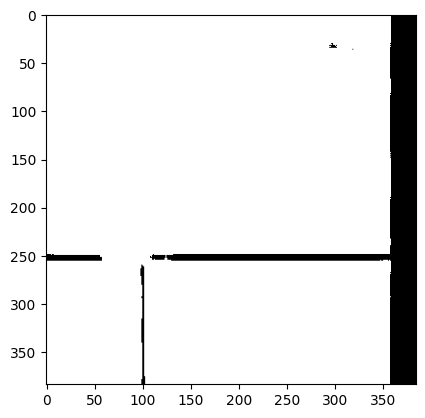

In [26]:
image_path_1 = 'best_model_3_pred\pred_mask_raw\pred_mask_raw_53.png'
image1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
image1 = np.array(image1)
plt.imshow(image1, cmap = 'gray')

In [43]:
def visualize_pipe(image_path_1):
    image1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
    # -------------------------------------------------------------------------------
    def invert(imagem):
        return (255 - imagem)
    # -------------------------------------------------------------------------------
    og_smoothed = smooth_edges(image1)
    og_smoothed_copy = og_smoothed.copy()
    # -------------------------------------------------------------------------------
    edges_1 = cv2.Canny(og_smoothed_copy, threshold1=50, threshold2=100)
    # -------------------------------------------------------------------------------
    testing_1 = morphing(edges_1)
    # -------------------------------------------------------------------------------
    lines1 = cv2.HoughLinesP(testing_1, 2, np.pi/180, threshold=25, 
                             minLineLength=10, maxLineGap=30)
    # -------------------------------------------------------------------------------
    vertical_lines1, horizontal_lines1 = classify_line(lines1)
    output_test_hor  = group_line_and_outlier(horizontal_lines1)
    output_test_ver  = group_line_and_outlier(vertical_lines1)
    final_merged_list_hor = merge_lists_with_common_line(output_test_hor)
    final_merged_list_ver = merge_lists_with_common_line(output_test_ver)
    allies = final_merged_list_hor + final_merged_list_ver
    # -------------------------------------------------------------------------------
    hough_1 = create_image_with_hough_lines(testing_1, allies, is_binary=False)
    # -------------------------------------------------------------------------------
    hough_1_straight = cv2.morphologyEx(hough_1, cv2.MORPH_CLOSE, 
                                        cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    # -------------------------------------------------------------------------------
    
    hough_classified1 = create_image_with_classified_lines(testing_1, final_merged_list_hor, final_merged_list_ver)
    
    #hough_classified1 = create_image_with_classified_lines(testing_1, vertical_lines1, horizontal_lines1)
    
    # -------------------------------------------------------------------------------
    border_lines = get_border_lines(hough_1.shape)
    intersections1 = find_intersection(final_merged_list_ver, final_merged_list_hor)
    
    vertical_border1 = [point for point in find_intersection(final_merged_list_ver, border_lines) 
                        if point is not None and all(0 <= coord <= 400 for coord in point)]
    horizontal_border1 = [point for point in find_intersection(final_merged_list_hor, border_lines) 
                          if point is not None and all(0 <= coord <= 400 for coord in point)]

    intersections_full1 = np.array(intersections1 + vertical_border1 + horizontal_border1)
    border_inter1 = np.array(vertical_border1 + horizontal_border1)
    intersections1 = np.array(intersections1)
    # -------------------------------------------------------------------------------
    hough_classified1_copy = hough_classified1.copy()
    for point in intersections1:
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (0, 255, 0), -1)  
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (255, 255, 255), 1)
    for point in border_inter1:
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (0, 255, 0), -1)  
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (255, 255, 255), 1)
    # -------------------------------------------------------------------------------
    if len(intersections1) > 0:
        mean_shift_inner = MeanShift(bandwidth=13)  
        labels_inner = mean_shift_inner.fit_predict(intersections1)
        centroids_inner = mean_shift_inner.cluster_centers_
    else: 
        centroids_inner = np.array([]).reshape(0, 2)
        labels_inner = np.array([])

    mean_shift_border = MeanShift(bandwidth=10)  
    labels_border = mean_shift_border.fit_predict(border_inter1)
    centroids_border = mean_shift_border.cluster_centers_

    labels = np.concatenate((labels_inner, labels_border + 200))
    centroids = np.concatenate((centroids_inner, centroids_border))
    # -------------------------------------------------------------------------------
    intersections1_clustered = hough_classified1.copy()
    for centroid in centroids:
        x, y = int(centroid[0]), int(centroid[1])
        intersections1_clustered = cv2.drawMarker(
            intersections1_clustered,
            (x, y),
            color=(255, 255, 255),  
            markerType=cv2.MARKER_CROSS, 
            markerSize=7, 
            thickness=2
        )
    # -------------------------------------------------------------------------------
    ve_len = draw_centroid_connection(hough_classified1, og_smoothed_copy, centroids)
    original = r"best_model_3_pred\img\img_53.png"
    original_gray = cv2.imread(original, cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    axes = axes.flatten()
    
    # Plot the pipeline stages:
    axes[0].imshow(original_gray, cmap='gray')
    axes[0].set_title("True Mask")
    axes[0].axis('off')    
    # -------------------------------------------------------------------------------
    axes[1].imshow(image1, cmap='gray')
    axes[1].set_title("Raw Output")
    axes[1].axis('off')
    # -------------------------------------------------------------------------------
    axes[2].imshow(og_smoothed, cmap='gray')
    axes[2].set_title("Smoothed")
    axes[2].axis('off')
    # -------------------------------------------------------------------------------
    axes[3].imshow(edges_1, cmap='gray')
    axes[3].set_title("Canny-Detected Edges")
    axes[3].axis('off')
    # -------------------------------------------------------------------------------
    axes[4].imshow(testing_1, cmap='gray')
    axes[4].set_title("Morphed")
    axes[4].axis('off')
    # -------------------------------------------------------------------------------
    axes[5].imshow(hough_1, cmap='gray')
    axes[5].set_title("Hough Lines Transformed")
    axes[5].axis('off')
    # -------------------------------------------------------------------------------
    axes[6].imshow(hough_classified1, cmap='gray')
    axes[6].set_title("Hough Classified")
    axes[6].axis('off')
    # -------------------------------------------------------------------------------
    axes[7].imshow(hough_classified1_copy, cmap='gray')
    axes[7].set_title("Hough Classified with Intersections")
    axes[7].axis('off')
    # -------------------------------------------------------------------------------
    ax_cluster = axes[8]
    unique_clusters = set(labels)
    for cluster in unique_clusters:
        if cluster == -1: 
            continue
        mask = labels == cluster
        cluster_points = intersections_full1[mask]  
        color = np.random.rand(3,)  
        ax_cluster.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f"Cluster {cluster}")
    ax_cluster.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
    ax_cluster.invert_yaxis()
    ax_cluster.grid(alpha = .3)
    ax_cluster.set_title("Mean Shift Clustering with Centroids")

    # -------------------------------------------------------------------------------
    axes[9].imshow(intersections1_clustered, cmap='gray')
    axes[9].set_title("Hough with Centroids")
    axes[9].axis('off')

    intersections1_connected = intersections1_clustered.copy()

    for i, point1 in enumerate(centroids):
        for j, point2 in enumerate(centroids):
            if i != j:
                x1, y1 = int(point1[0]), int(point1[1])
                x2, y2 = int(point2[0]), int(point2[1])

                if is_connection_valid(intersections1_connected, x1, y1, x2, y2):
                    cv2.line(
                        intersections1_connected,
                        (x1, y1),
                        (x2, y2),
                        color=(0, 255, 0),
                        thickness=2
                    )

    # -------------------------------------------------------------------------------
    axes[10].imshow(intersections1_connected, cmap='gray')
    axes[10].set_title("Connecting Lines Between Centroids")
    axes[10].axis('off')
    # -------------------------------------------------------------------------------
    axes[11].imshow(ve_len, cmap = 'gray')
    axes[11].set_title("Final Output")
    axes[11].axis('off')

    if len(axes) > 11:
        for ax in axes[11:]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


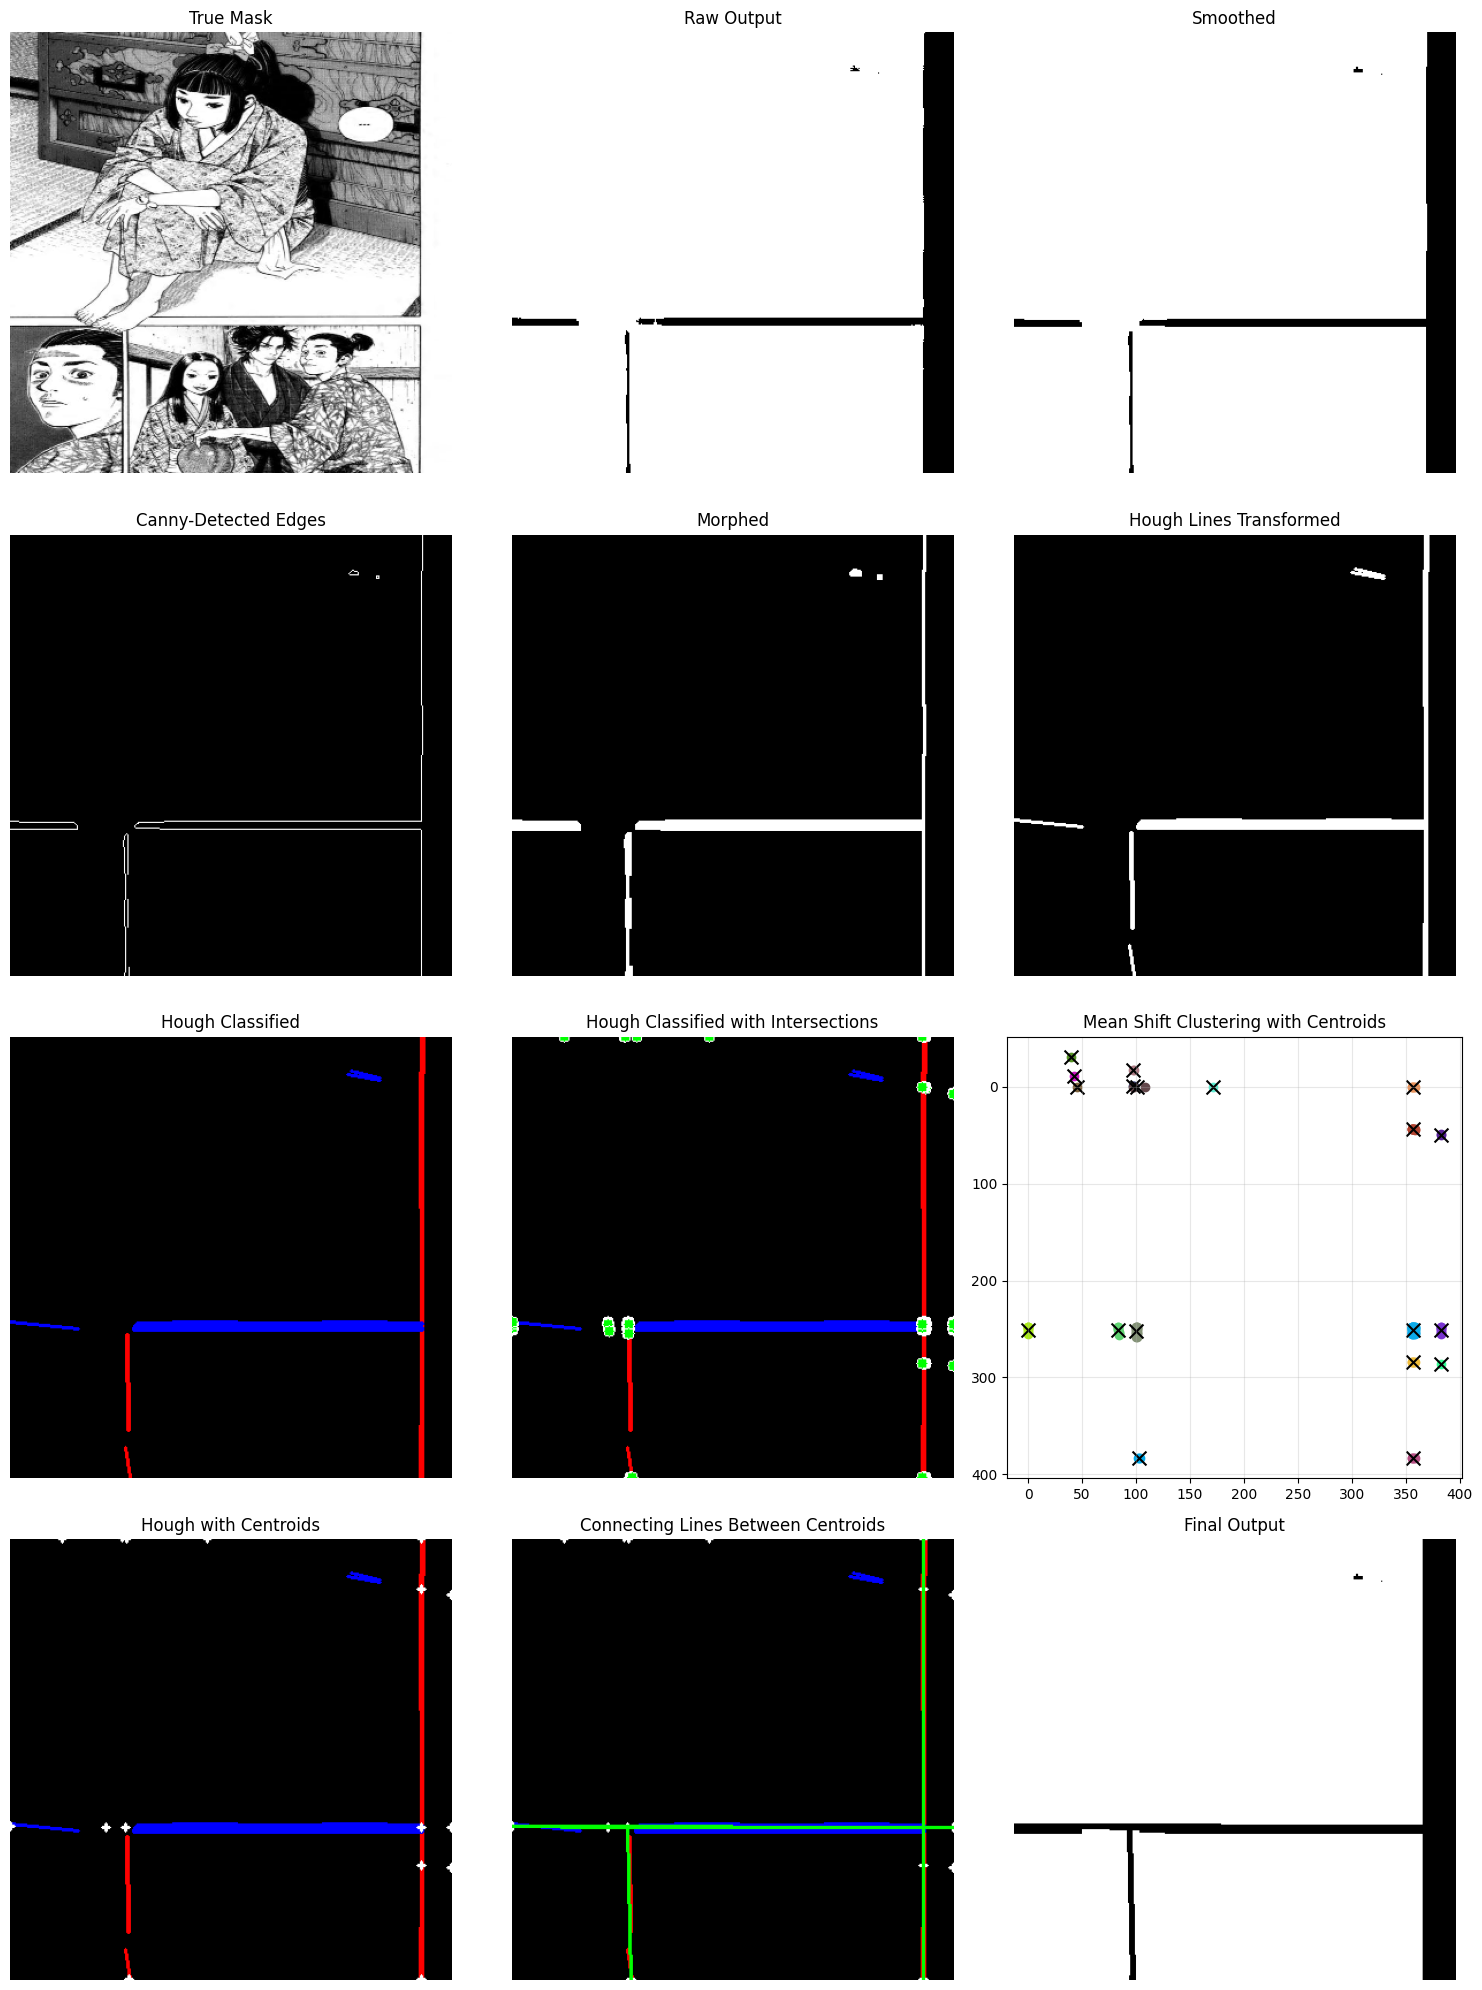

In [ ]:
visualize_pipe(image_path_1)    

---

In [41]:
def visualize_pipe_separate(image_path_1):
    image1 = cv2.imread(image_path_1, cv2.IMREAD_GRAYSCALE)
    
    def invert(imagem):
        return (255 - imagem)
    
    # Pipeline processing
    og_smoothed = smooth_edges(image1)
    og_smoothed_copy = og_smoothed.copy()
    edges_1 = cv2.Canny(og_smoothed_copy, threshold1=50, threshold2=100)
    testing_1 = morphing(edges_1)
    lines1 = cv2.HoughLinesP(testing_1, 2, np.pi / 180, threshold=25, minLineLength=10, maxLineGap=30)
    
    vertical_lines1, horizontal_lines1 = classify_line(lines1)
    output_test_hor = group_line_and_outlier(horizontal_lines1)
    output_test_ver = group_line_and_outlier(vertical_lines1)
    final_merged_list_hor = merge_lists_with_common_line(output_test_hor)
    final_merged_list_ver = merge_lists_with_common_line(output_test_ver)
    allies = final_merged_list_hor + final_merged_list_ver
    
    hough_1 = create_image_with_hough_lines(testing_1, allies, is_binary=False)
    hough_classified1 = create_image_with_classified_lines(testing_1, final_merged_list_hor, final_merged_list_ver)
    
    # Finding intersections
    border_lines = get_border_lines(hough_1.shape)
    intersections1 = find_intersection(final_merged_list_ver, final_merged_list_hor)
    vertical_border1 = [point for point in find_intersection(final_merged_list_ver, border_lines) 
                        if point is not None and all(0 <= coord <= 400 for coord in point)]
    horizontal_border1 = [point for point in find_intersection(final_merged_list_hor, border_lines) 
                          if point is not None and all(0 <= coord <= 400 for coord in point)]
    
    intersections_full1 = np.array(intersections1 + vertical_border1 + horizontal_border1)
    border_inter1 = np.array(vertical_border1 + horizontal_border1)
    intersections1 = np.array(intersections1)
    
    hough_classified1_copy = hough_classified1.copy()
    for point in intersections1:
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (0, 255, 0), -1)
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (255, 255, 255), 1)
    for point in border_inter1:
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (0, 255, 0), -1)
        cv2.circle(hough_classified1_copy, (point[0], point[1]), 5, (255, 255, 255), 1)
    
    # MeanShift clustering
    if len(intersections1) > 0:
        mean_shift_inner = MeanShift(bandwidth=13)
        labels_inner = mean_shift_inner.fit_predict(intersections1)
        centroids_inner = mean_shift_inner.cluster_centers_
    else:
        centroids_inner = np.array([]).reshape(0, 2)
        labels_inner = np.array([])
    
    mean_shift_border = MeanShift(bandwidth=10)
    labels_border = mean_shift_border.fit_predict(border_inter1)
    centroids_border = mean_shift_border.cluster_centers_
    
    labels = np.concatenate((labels_inner, labels_border + 200))
    centroids = np.concatenate((centroids_inner, centroids_border))
    
    # Connecting centroids
    intersections1_connected = hough_classified1.copy()
    for i, point1 in enumerate(centroids):
        for j, point2 in enumerate(centroids):
            if i != j:
                x1, y1 = int(point1[0]), int(point1[1])
                x2, y2 = int(point2[0]), int(point2[1])
                
                if is_connection_valid(intersections1_connected, x1, y1, x2, y2):
                    cv2.line(
                        intersections1_connected,
                        (x1, y1),
                        (x2, y2),
                        color=(0, 255, 0),
                        thickness=2
                    )
    
    ve_len = draw_centroid_connection(hough_classified1, og_smoothed_copy, centroids)
    original = r"best_model_3_pred\img\img_53.png"
    original_gray = cv2.imread(original, cv2.IMREAD_GRAYSCALE)
    
    # Individual plots
    def plot_figure(image, title):
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()
    
    # Plot each stage
    plot_figure(original_gray, "True Mask")
    plot_figure(image1, "Raw Output")
    plot_figure(og_smoothed, "Smoothed")
    plot_figure(edges_1, "Canny-Detected Edges")
    plot_figure(testing_1, "Morphed")
    plot_figure(hough_1, "Hough Lines Transformed")
    plot_figure(hough_classified1, "Hough Classified")
    plot_figure(hough_classified1_copy, "Hough Classified with Intersections")
    
    # Plot clustering
    plt.figure(figsize = (4.2, 5))
    unique_clusters = set(labels)
    for cluster in unique_clusters:
        if cluster == -1:
            continue
        mask = labels == cluster
        cluster_points = intersections_full1[mask]
        color = np.random.rand(3,)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f"Cluster {cluster}")
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3)
    plt.title("Mean Shift Clustering with Centroids")
    # plt.legend()
    plt.show()
    
    plot_figure(intersections1_connected, "Connecting Lines Between Centroids")
    plot_figure(ve_len, "Final Output")


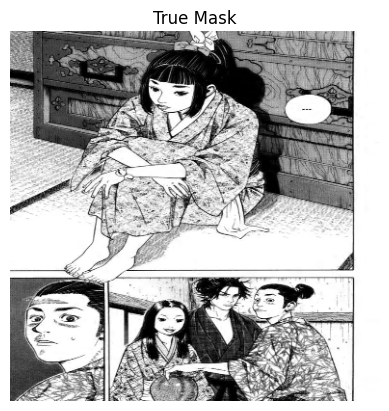

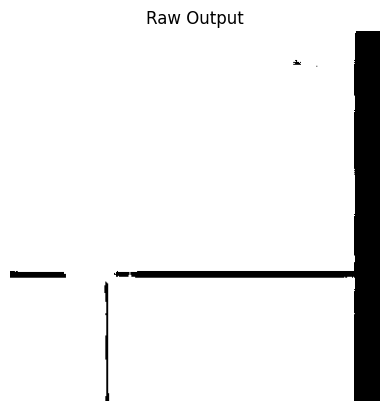

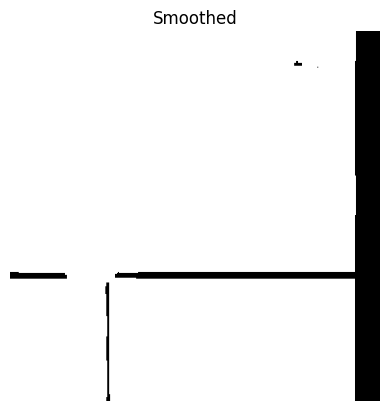

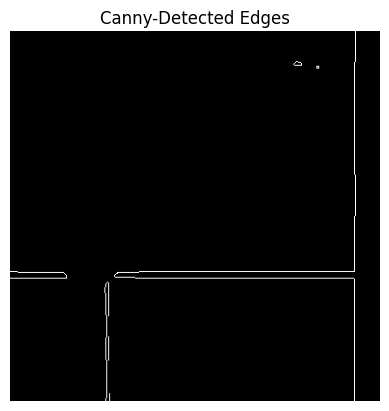

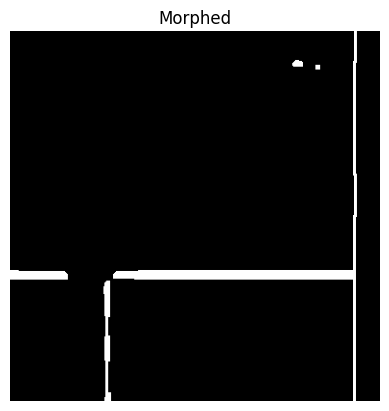

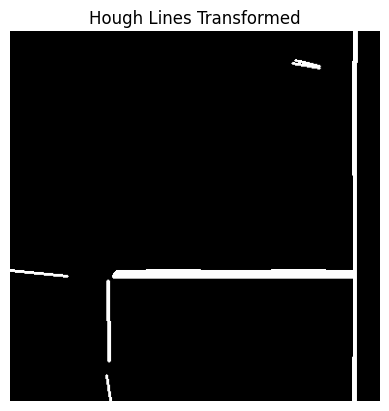

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


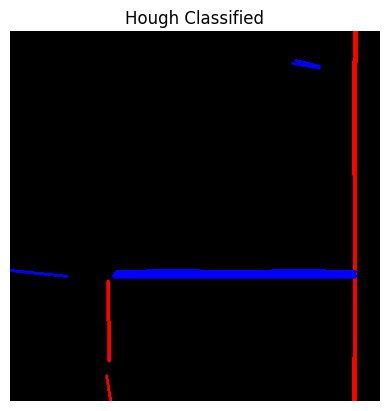

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


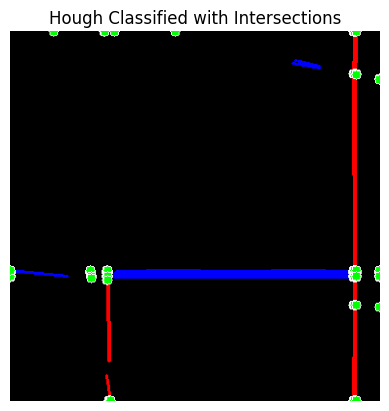

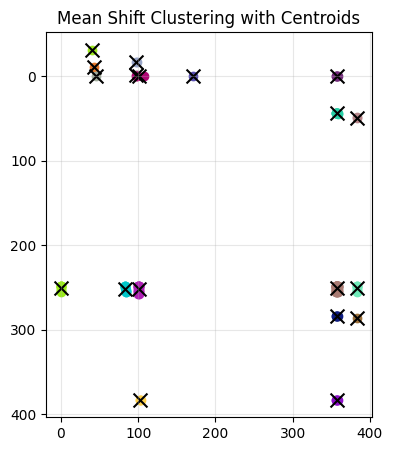

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


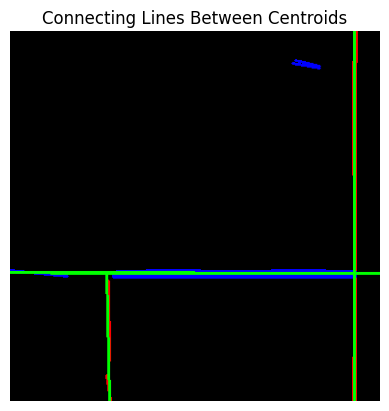

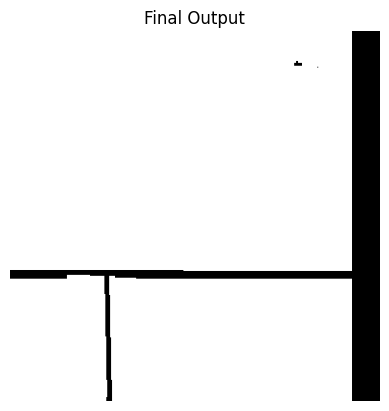

In [42]:
visualize_pipe_separate(image_path_1)